<a id='section_id'></a>

<h1> <div align="center"><a> Обучение модели классификации комментариев </a></div>    

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re 

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, plot_confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
display(data.head())
data.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Выборка очень большая: таблица имеет почти 160 тысяч строк. Используемый язык - **английский**. Пропусков нет, перименовывать столбцы не нужно.

### Приведение к нижнему регистру
Добавим столбец, где все буквы будут строчными.

In [3]:
%%time
data['low_text'] = data['text'].str.lower()
data.head()

CPU times: user 224 ms, sys: 43.7 ms, total: 267 ms
Wall time: 267 ms


,text,toxic,low_text
0,Explanation\nWhy the edits made under my usern...,0,explanation\nwhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,0,d'aww! he matches this background colour i'm s...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, i'm really not trying to edit war. it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"""\nmore\ni can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember...",0,"you, sir, are my hero. any chance you remember..."


### Лемматизация
Напишем функцию, которая сначала проводит токенизацию, а затем лемматизацию текста с помощью **WordNetLemmatizer**.

In [4]:
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    wnl = WordNetLemmatizer()
    lemmatized_output = ' '.join([wnl.lemmatize(w, pos='v') for w in word_list])
    return lemmatized_output

print("Исходный текст:", data['text'][0])
print("_"*100)
print("Лемматизированный текст:", lemmatize(data['low_text'][0]))

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
____________________________________________________________________________________________________
Лемматизированный текст: explanation why the edit make under my username hardcore metallica fan be revert ? they be n't vandalisms , just closure on some gas after i vote at new york dolls fac . and please do n't remove the template from the talk page since i 'm retire now.89.205.38.27


In [5]:
%%time
data['lemm_text'] = data['low_text'].apply(lemmatize)
data.head()

CPU times: user 2min 10s, sys: 431 ms, total: 2min 11s
Wall time: 2min 12s


,text,toxic,low_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation\nwhy the edits made under my usern...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d'aww! he matches this background colour i'm s...,d'aww ! he match this background colour i 'm s...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, i'm really not trying to edit war. it...","hey man , i 'm really not try to edit war . it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"""\nmore\ni can't make any real suggestions on ...",`` more i ca n't make any real suggestions on ...
4,"You, sir, are my hero. Any chance you remember...",0,"you, sir, are my hero. any chance you remember...","you , sir , be my hero . any chance you rememb..."


### Регуляризация
В лемматизированном тексте нужно оставить только латинские символы и пробелы. Чтобы их найти, напишем регулярное выражение.

In [6]:
def clear_text(text):
    english_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = " ".join(english_text.split())
    return clear_text

print("Исходный текст:", data['text'][0])
print("_"*100)
print("Лемматизированный и очищенный текст:", clear_text(lemmatize(data['low_text'][0])))

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
____________________________________________________________________________________________________
Лемматизированный и очищенный текст: explanation why the edit make under my username hardcore metallica fan be revert they be n t vandalisms just closure on some gas after i vote at new york dolls fac and please do n t remove the template from the talk page since i m retire now


In [7]:
%%time
data['clear_text'] = data['lemm_text'].apply(clear_text)
data.head()

CPU times: user 4.27 s, sys: 28 ms, total: 4.3 s
Wall time: 4.31 s


,text,toxic,low_text,lemm_text,clear_text
0,Explanation\nWhy the edits made under my usern...,0,explanation\nwhy the edits made under my usern...,explanation why the edit make under my usernam...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d'aww! he matches this background colour i'm s...,d'aww ! he match this background colour i 'm s...,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, i'm really not trying to edit war. it...","hey man , i 'm really not try to edit war . it...",hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,"""\nmore\ni can't make any real suggestions on ...",`` more i ca n't make any real suggestions on ...,more i ca n t make any real suggestions on imp...
4,"You, sir, are my hero. Any chance you remember...",0,"you, sir, are my hero. any chance you remember...","you , sir , be my hero . any chance you rememb...",you sir be my hero any chance you remember wha...


## Обучение
### Разделение выборок

Сначала оценим долю целевого признака в общей выборке.

In [8]:
data["toxic"].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Доля токсичных комментариев составила около 10% от общей выборки - налицо дисбаланс классов. **При разбиении на обучающую и тестовую выборки сохраним долю целевого признака в обеих выборках с помощью параметра stratify, а при обучении моделей используем class_weight="balanced".** Разобьем данные на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Установим их согласно на уровне 10%.

In [9]:
train, middle = train_test_split(data, test_size=0.2, random_state=12345, stratify=data['toxic'])
valid, test = train_test_split(middle, test_size=0.5, random_state=12345, stratify=middle['toxic'])

print(train.shape, valid.shape, test.shape)

(127656, 5) (15957, 5) (15958, 5)


In [10]:
#  объявим переменные с признаками и целевым признаком для каждой из полученных выборок
x_train = train['clear_text']
y_train = train['toxic']
x_valid = valid['clear_text']
y_valid = valid['toxic']
x_test = test['clear_text']
y_test = test['toxic']

### Создание признаков

Создадим мешок слов, биграммы и TF-IDF с учетом стоп-слов.

#### Мешок слов

In [11]:
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))
count_vect_bow = CountVectorizer(stop_words=stop_words)

bow_train = count_vect_bow.fit_transform(x_train) 
bow_valid = count_vect_bow.transform(x_valid) 
bow_test = count_vect_bow.transform(x_test) 

print("Размеры матриц:", bow_train.shape, bow_valid.shape, bow_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размеры матриц: (127656, 139822) (15957, 139822) (15958, 139822)


#### Биграммы

In [12]:
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))
count_vect_bi = CountVectorizer(stop_words=stop_words, ngram_range=(2, 2)) 

n_gramm_train = count_vect_bi.fit_transform(x_train) 
n_gramm_valid = count_vect_bi.transform(x_valid)
n_gramm_test = count_vect_bi.transform(x_test)

print("Размеры биграмм:", n_gramm_train.shape, n_gramm_valid.shape, n_gramm_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размеры биграмм: (127656, 1981750) (15957, 1981750) (15958, 1981750)


Ожидаемо, количество биграмм в разы превышает количество самих слов.

#### TF-IDF

In [13]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

tf_idf_train = count_tf_idf.fit_transform(x_train)
tf_idf_valid = count_tf_idf.transform(x_valid)
tf_idf_test = count_tf_idf.transform(x_test)

print("Размеры матриц:", tf_idf_train.shape, tf_idf_valid.shape, tf_idf_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размеры матриц: (127656, 139822) (15957, 139822) (15958, 139822)


Признаков столько же, сколько и у мешка слов, мы ничего не потеряли.

### Логистическая регрессия и выбор признаков
**Опробуем все три вида признаков на модели логистической регрессии и все последующие модели будем обучать уже только на признаках, которые показали наилучший результат.**

In [14]:
%%time
lr = LogisticRegression(max_iter=100, class_weight="balanced", n_jobs=-1) 
lr.fit(bow_train, y_train)
predicted_valid = lr.predict(bow_valid)
result = f1_score(y_valid, predicted_valid)
print("F1-мера на валидационной выборке:", result)

F1-мера на валидационной выборке: 0.7788516202387721
CPU times: user 25.5 s, sys: 25 s, total: 50.5 s
Wall time: 52 s


In [15]:
%%time
lr = LogisticRegression(max_iter=100, class_weight="balanced", n_jobs=-1) 
lr.fit(n_gramm_train, y_train)
predicted_valid = lr.predict(n_gramm_valid)
result = f1_score(y_valid, predicted_valid)
print("F1-мера на валидационной выборке:", result)

F1-мера на валидационной выборке: 0.562187139006546
CPU times: user 1min 19s, sys: 44.9 s, total: 2min 4s
Wall time: 2min 4s


In [16]:
%%time
lr = LogisticRegression(max_iter=100, class_weight="balanced", n_jobs=-1) 
lr.fit(tf_idf_train, y_train)
predicted_valid = lr.predict(tf_idf_valid)
result = f1_score(y_valid, predicted_valid)
print("F1-мера на валидационной выборке:", result)

F1-мера на валидационной выборке: 0.7637153720803912
CPU times: user 23.8 s, sys: 25.5 s, total: 49.3 s
Wall time: 49.3 s


Наилучший результат продемонстрировали признаки из мешка слов (f1 = 0.78), чуть хуже tf-idf (f1 = 0.76). Использование биграмм дало самый слабый результат: f1 = 0.56. В целом полученные результаты выглядят вполне логично, поскольку токсичность комментариев определяется употреблением конкретных слов и не так важно, насколько часто это слово упоминается в тексте или в каком соседстве. **Для последующего обучения моделей будем использовать мешок слов.**

### Решающее дерево
Подберем гиперпараметры с помощью **HalvingGridSearchCV**.

In [18]:
# ячейка с подбором гиперпараметров деактивирована специально, чтобы можно было быстро пересчитать весь проект 
# %%time
# parametrs = {'max_depth': range (20, 51)}
# dtr = DecisionTreeClassifier (random_state=12345, class_weight="balanced")
# grid = HalvingGridSearchCV(dtr, parametrs, scoring = 'f1', cv = 3, verbose = 2, random_state=12345)
# grid.fit(bow_train, y_train) 
# grid.best_params_

In [19]:
%%time
dtr = DecisionTreeClassifier (random_state=12345, class_weight="balanced", max_depth=49)
dtr.fit(bow_train, y_train)
predicted_valid = dtr.predict(bow_valid)
result = f1_score(y_valid, predicted_valid)
print("F1-мера на валидационной выборке:", result)

F1-мера на валидационной выборке: 0.6866151866151866
CPU times: user 40 s, sys: 0 ns, total: 40 s
Wall time: 40 s


### Случайный лес
Подберем гиперпараметры с помощью нескольких итерраций **HalvingGridSearchCV** (промежуточные итеррации пропущены для сокращения кода).

In [20]:
# ячейка с подбором гиперпараметров деактивирована специально, чтобы можно было быстро пересчитать весь проект 

# %%time
# parametrs = {'n_estimators': range (64, 69, 2),
#             'max_depth': range (74, 79, 2)}
# model = RandomForestClassifier (random_state=12345, class_weight="balanced")
# grid = HalvingGridSearchCV(model, parametrs, scoring = 'f1', cv = 3, verbose = 2, random_state=12345)
# grid.fit(bow_train, y_train) 
# grid.best_params_

In [21]:
%%time
rf = RandomForestClassifier (random_state=12345, 
                             n_estimators=68, 
                             max_depth=78, 
                             class_weight="balanced", 
                             n_jobs=-1)

rf.fit(bow_train, y_train)
predicted_valid = rf.predict(bow_valid)

result = f1_score(y_valid, predicted_valid)
print("F1-мера на валидационной выборке:", result)

F1-мера на валидационной выборке: 0.509282700421941
CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 39s


### Градиентный бустинг CatBoost

In [22]:
# библиотека CatBoost умеет работать с текстом напрямую, поэтому используем исходные выборки, добавивив в них название столбца
x_train = pd.DataFrame(x_train, columns = ['clear_text'])
x_valid = pd.DataFrame(x_valid, columns = ['clear_text'])
x_test = pd.DataFrame(x_test, columns = ['clear_text'])

In [23]:
%%time
cb = CatBoostClassifier(eval_metric = "F1",
                        loss_function="Logloss",
                        iterations=100,
                        verbose=2)

text_features= ['clear_text']

cb.fit(x_train, y_train, text_features=text_features) 
predicted_valid = cb.predict(x_valid)
result = f1_score(y_valid, predicted_valid)
print("F1-мера на валидационной выборке:", result)

Learning rate set to 0.5
0:	learn: 0.6989814	total: 541ms	remaining: 53.5s
2:	learn: 0.7094051	total: 1.52s	remaining: 49.2s
4:	learn: 0.7203889	total: 2.54s	remaining: 48.4s
6:	learn: 0.7243636	total: 3.6s	remaining: 47.9s
8:	learn: 0.7297079	total: 4.67s	remaining: 47.2s
10:	learn: 0.7336327	total: 5.71s	remaining: 46.2s
12:	learn: 0.7408924	total: 6.73s	remaining: 45s
14:	learn: 0.7446402	total: 7.75s	remaining: 43.9s
16:	learn: 0.7493710	total: 8.69s	remaining: 42.4s
18:	learn: 0.7526085	total: 9.61s	remaining: 41s
20:	learn: 0.7550064	total: 10.6s	remaining: 39.7s
22:	learn: 0.7573329	total: 11.5s	remaining: 38.6s
24:	learn: 0.7604042	total: 12.5s	remaining: 37.5s
26:	learn: 0.7625355	total: 13.4s	remaining: 36.3s
28:	learn: 0.7633045	total: 14.4s	remaining: 35.2s
30:	learn: 0.7656056	total: 15.4s	remaining: 34.2s
32:	learn: 0.7674130	total: 16.3s	remaining: 33.1s
34:	learn: 0.7678747	total: 17.3s	remaining: 32.2s
36:	learn: 0.7701493	total: 18.3s	remaining: 31.2s
38:	learn: 0.770

### Градиентный бустинг LGBM

In [24]:
# библиотека LightGBM требует обязательного присвоения количественным признакам типа float32/64 
bow_train_float = bow_train.astype('float32')
bow_valid_float = bow_valid.astype('float32')
bow_test_float = bow_test.astype('float32')

In [25]:
%%time
lg = LGBMClassifier(max_depth=- 1, 
                    learning_rate=0.5, 
                    n_estimators=100,
                    n_jobs=-1)

lg .fit(bow_train_float, y_train)
predicted_valid = lg.predict(bow_valid_float)

result = f1_score(y_valid, predicted_valid)
print("F1-мера на валидационной выборке:", result)

F1-мера на валидационной выборке: 0.7906819716407831
CPU times: user 1min 21s, sys: 0 ns, total: 1min 21s
Wall time: 1min 21s


### Градиентный бустинг XGBoost

In [26]:
%%time
xgb = XGBClassifier(verbosity  = 2, 
                    use_label_encoder=False, 
                    eval_metric='logloss',
                    n_jobs=-1)

xgb.fit(bow_train, y_train)
predicted_valid = xgb.predict(bow_valid)

result = f1_score(y_valid, predicted_valid)
print("F1-мера на валидационной выборке:", result)

[16:40:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:40:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[16:40:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[16:40:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[16:40:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:40:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[16:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:40:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:40:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned no

### Константная модель

In [27]:
dc = DummyClassifier(strategy='constant', random_state=12345, constant =1).fit(tf_idf_train, y_train) 
predicted_valid = dc.predict(tf_idf_valid)
result = f1_score(y_valid, predicted_valid)
print("F1-мера на валидационной выборке:", result)

F1-мера на валидационной выборке: 0.18453836964559986


## Выводы

In [28]:
pd.DataFrame({'Модель': ["Линейная регрессия", "Решающее дерево", "Случайный лес", "CatBoost", "LightGBM", "XGBoost", "Константная модель"],
              'F1': [0.78, 0.68, 0.51, 0.79, 0.79, 0.73, 0.18]}).T

,0,1,2,3,4,5,6
Модель,Линейная регрессия,Решающее дерево,Случайный лес,CatBoost,LightGBM,XGBoost,Константная модель
F1,0.78,0.68,0.51,0.79,0.79,0.73,0.18


Наилучший результат F1 продемонстрировали модели градиентного бустинга Catboost и LightGBM (f1 = 0.79). Чуть хуже результат у линейной регрессии (f1 = 0.78). По скорости оубчения выигрывает **Catboost**, поэтому проверим результат на тестовой выборке и выведем основные влияющие факторы согласно этой модели.

In [29]:
%%time
predicted_valid = cb.predict(x_test)
result = f1_score(y_test, predicted_valid)
print("F1-мера на валидационной выборке:", result)

F1-мера на валидационной выборке: 0.7678145243777703
CPU times: user 618 ms, sys: 0 ns, total: 618 ms
Wall time: 631 ms


**Построим матрицу ошибок и выведем основные показатели классификации.**

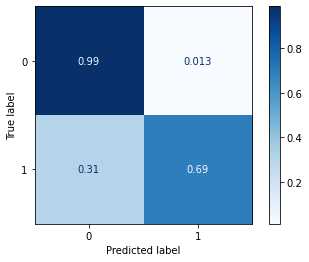

In [30]:
plot_confusion_matrix(estimator=cb, X=x_test, y_true=y_test,
                      normalize="true", cmap="Blues")
plt.show()

In [31]:
print(classification_report(y_test, cb.predict(x_test), target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14335
           1       0.86      0.69      0.77      1623

    accuracy                           0.96     15958
   macro avg       0.91      0.84      0.87     15958
weighted avg       0.96      0.96      0.96     15958



**Основные выводы:**
 * в первую очередь стоит отметить, что все обученные модели продемонстрировали точность в разы лучше, нежели константаная модель, которая все комментарии расценивала как токсичные;
 * **наибольшую точность продемонстрировала модель градиентного бустинга Catboost**, чуть хуже модели градиентного бустинга LightGBM и линейной регрессии;
 * На основании матрицы ошибок мы видим, что выбранная нами модель почти на 60% лучше в определении токсичности комментариев, нежели константная модель, для которой recall равен 10%.
 * Полученный результат на тестовой выборке F1-меры равен 0.77, что превышает необходимый уровень 0.75. 